<a href="https://colab.research.google.com/github/anantp316/Gender-Recognition-by-Voice---Classification/blob/main/Gender_Recognition_by_Voice_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement


### **Gender Recognition by Voice and Speech Analysis** - This is a dataset originally created to identify a voice as male or female, based upon acoustic properties of the voice and speech. The dataset consists of 3,168 recorded voice samples, collected from male and female speakers. The voice samples are pre-processed by acoustic analysis in R using the seewave and tuneR packages, with an analyzed frequency range of 0hz-280hz (human vocal range).




## **Aim** - Split the given dataset into training and validation datasets and build a classifier on the training data and validate its performance on the validation dataset.

# Loading the data from Kaggle

You may need to use the Kaggle API token to load data into Google Colab environment.

**Note** - This is only for Google Colab users.

In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
!kaggle datasets download primaryobjects/voicegender

voicegender.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!unzip *.zip

Archive:  voicegender.zip
replace voice.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Importing Libraries

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, GaussianNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import sklearn.metrics
import sklearn.model_selection

# Data Preparation

In [6]:
dataframe = pd.read_csv("/content/voice.csv")
dataframe.head()

meanfreq        sd    median       Q25       Q75       IQR       skew  \
0  0.059781  0.064241  0.032027  0.015071  0.090193  0.075122  12.863462   
1  0.066009  0.067310  0.040229  0.019414  0.092666  0.073252  22.423285   
2  0.077316  0.083829  0.036718  0.008701  0.131908  0.123207  30.757155   
3  0.151228  0.072111  0.158011  0.096582  0.207955  0.111374   1.232831   
4  0.135120  0.079146  0.124656  0.078720  0.206045  0.127325   1.101174   

          kurt    sp.ent       sfm  ...  centroid   meanfun    minfun  \
0   274.402906  0.893369  0.491918  ...  0.059781  0.084279  0.015702   
1   634.613855  0.892193  0.513724  ...  0.066009  0.107937  0.015826   
2  1024.927705  0.846389  0.478905  ...  0.077316  0.098706  0.015656   
3     4.177296  0.963322  0.727232  ...  0.151228  0.088965  0.017798   
4     4.333713  0.971955  0.783568  ...  0.135120  0.106398  0.016931   

     maxfun   meandom    mindom    maxdom   dfrange   modindx  label  
0  0.275862  0.007812  0.007812  0.007812  0.000000  0.000000   male  
1  0.250000  0.009014  0.007812  0.054688  0.046875  0.052632   male  
2  0.271186  0.007990  0.007812  0.015625  0.007812  0.046512   male  
3  0.250000  0.201497  0.007812  0.562500  0.554688  0.247119   male  
4  0.266667  0.712812  0.007812  5.484375  5.476562  0.208274   male  

[5 rows x 21 columns]

In [7]:
dataframe.count()

meanfreq    3168
sd          3168
median      3168
Q25         3168
Q75         3168
IQR         3168
skew        3168
kurt        3168
sp.ent      3168
sfm         3168
mode        3168
centroid    3168
meanfun     3168
minfun      3168
maxfun      3168
meandom     3168
mindom      3168
maxdom      3168
dfrange     3168
modindx     3168
label       3168
dtype: int64

## Dataframe Properties

The following acoustic properties of each voice are measured and included in the dataset:

* **meanfreq**: mean frequency (in kHz)
* **sd**: standard deviation of frequency
* **median**: median frequency (in kHz)
* **Q25**: first quantile (in kHz)
* **Q75**: third quantile (in kHz)
* **IQR**: interquantile range (in kHz)
* **skew**: skewness (see note in specprop description)
* **kurt**: kurtosis (see note in specprop description)
* **sp.ent**: spectral entropy
* **sfm**: spectral flatness
* **mode**: mode frequency
* **centroid**: frequency centroid (see specprop)
* **peakf**: peak frequency (frequency with highest energy)
* **meanfun**: average of fundamental frequency measured across acoustic signal
* **minfun**: minimum fundamental frequency measured across acoustic signal
* **maxfun**: maximum fundamental frequency measured across acoustic signal
* **meandom**: average of dominant frequency measured across acoustic signal
* **mindom**: minimum of dominant frequency measured across acoustic signal
* **maxdom**: maximum of dominant frequency measured across acoustic signal
* **dfrange**: range of dominant frequency measured across acoustic signal
* **modindx**: modulation index. Calculated as the accumulated absolute difference  between adjacent measurements of fundamental frequencies divided by the frequency range
* **label**: male or female

In [8]:
dataframe.describe().T

count       mean         std       min       25%       50%  \
meanfreq  3168.0   0.180907    0.029918  0.039363  0.163662  0.184838   
sd        3168.0   0.057126    0.016652  0.018363  0.041954  0.059155   
median    3168.0   0.185621    0.036360  0.010975  0.169593  0.190032   
Q25       3168.0   0.140456    0.048680  0.000229  0.111087  0.140286   
Q75       3168.0   0.224765    0.023639  0.042946  0.208747  0.225684   
IQR       3168.0   0.084309    0.042783  0.014558  0.042560  0.094280   
skew      3168.0   3.140168    4.240529  0.141735  1.649569  2.197101   
kurt      3168.0  36.568461  134.928661  2.068455  5.669547  8.318463   
sp.ent    3168.0   0.895127    0.044980  0.738651  0.861811  0.901767   
sfm       3168.0   0.408216    0.177521  0.036876  0.258041  0.396335   
mode      3168.0   0.165282    0.077203  0.000000  0.118016  0.186599   
centroid  3168.0   0.180907    0.029918  0.039363  0.163662  0.184838   
meanfun   3168.0   0.142807    0.032304  0.055565  0.116998  0.140519   
minfun    3168.0   0.036802    0.019220  0.009775  0.018223  0.046110   
maxfun    3168.0   0.258842    0.030077  0.103093  0.253968  0.271186   
meandom   3168.0   0.829211    0.525205  0.007812  0.419828  0.765795   
mindom    3168.0   0.052647    0.063299  0.004883  0.007812  0.023438   
maxdom    3168.0   5.047277    3.521157  0.007812  2.070312  4.992188   
dfrange   3168.0   4.994630    3.520039  0.000000  2.044922  4.945312   
modindx   3168.0   0.173752    0.119454  0.000000  0.099766  0.139357   

                75%          max  
meanfreq   0.199146     0.251124  
sd         0.067020     0.115273  
median     0.210618     0.261224  
Q25        0.175939     0.247347  
Q75        0.243660     0.273469  
IQR        0.114175     0.252225  
skew       2.931694    34.725453  
kurt      13.648905  1309.612887  
sp.ent     0.928713     0.981997  
sfm        0.533676     0.842936  
mode       0.221104     0.280000  
centroid   0.199146     0.251124  
meanfun    0.169581     0.237636  
minfun     0.047904     0.204082  
maxfun     0.277457     0.279114  
meandom    1.177166     2.957682  
mindom     0.070312     0.458984  
maxdom     7.007812    21.867188  
dfrange    6.992188    21.843750  
modindx    0.209183     0.932374

Checking for nulls if any

In [9]:
dataframe.isnull().sum()

meanfreq    0
sd          0
median      0
Q25         0
Q75         0
IQR         0
skew        0
kurt        0
sp.ent      0
sfm         0
mode        0
centroid    0
meanfun     0
minfun      0
maxfun      0
meandom     0
mindom      0
maxdom      0
dfrange     0
modindx     0
label       0
dtype: int64

Luckily we have no null values in our dataframe.

# Data Preprocessing

In this section our aim is to - 


*   Perform  Label Encoding on Target variable.
*   Shuffle our dataset.
*   Then split the data into training and validation sets. (80-20 split).



In [10]:
dataframe.replace(to_replace="female", value=0, inplace=True)
dataframe.replace(to_replace="male", value=1, inplace=True)
dataframe.label.unique()

array([1, 0])

Before Shuffle

In [11]:
dataframe.head()

meanfreq        sd    median       Q25       Q75       IQR       skew  \
0  0.059781  0.064241  0.032027  0.015071  0.090193  0.075122  12.863462   
1  0.066009  0.067310  0.040229  0.019414  0.092666  0.073252  22.423285   
2  0.077316  0.083829  0.036718  0.008701  0.131908  0.123207  30.757155   
3  0.151228  0.072111  0.158011  0.096582  0.207955  0.111374   1.232831   
4  0.135120  0.079146  0.124656  0.078720  0.206045  0.127325   1.101174   

          kurt    sp.ent       sfm  ...  centroid   meanfun    minfun  \
0   274.402906  0.893369  0.491918  ...  0.059781  0.084279  0.015702   
1   634.613855  0.892193  0.513724  ...  0.066009  0.107937  0.015826   
2  1024.927705  0.846389  0.478905  ...  0.077316  0.098706  0.015656   
3     4.177296  0.963322  0.727232  ...  0.151228  0.088965  0.017798   
4     4.333713  0.971955  0.783568  ...  0.135120  0.106398  0.016931   

     maxfun   meandom    mindom    maxdom   dfrange   modindx  label  
0  0.275862  0.007812  0.007812  0.007812  0.000000  0.000000      1  
1  0.250000  0.009014  0.007812  0.054688  0.046875  0.052632      1  
2  0.271186  0.007990  0.007812  0.015625  0.007812  0.046512      1  
3  0.250000  0.201497  0.007812  0.562500  0.554688  0.247119      1  
4  0.266667  0.712812  0.007812  5.484375  5.476562  0.208274      1  

[5 rows x 21 columns]

In [12]:
dataframe = dataframe.sample(frac=1).reset_index(drop=True)

After Shuffle

In [13]:
dataframe.head()

meanfreq        sd    median       Q25       Q75       IQR      skew  \
0  0.192887  0.060981  0.205418  0.173604  0.235335  0.061731  1.784828   
1  0.199189  0.062084  0.217325  0.133881  0.255523  0.121642  1.723478   
2  0.165462  0.059223  0.173419  0.108086  0.209247  0.101161  1.320005   
3  0.187697  0.057318  0.199471  0.136066  0.228165  0.092099  1.723029   
4  0.173822  0.060250  0.177272  0.155259  0.213961  0.058702  3.400253   

        kurt    sp.ent       sfm  ...  centroid   meanfun    minfun    maxfun  \
0   5.514467  0.917975  0.499885  ...  0.192887  0.180511  0.025437  0.275862   
1   6.349982  0.904596  0.312727  ...  0.199189  0.123837  0.047337  0.277457   
2   4.828746  0.936471  0.509378  ...  0.165462  0.107460  0.016719  0.246154   
3   6.210527  0.902901  0.358652  ...  0.187697  0.120987  0.048682  0.274286   
4  30.849994  0.923001  0.504066  ...  0.173822  0.174866  0.056338  0.238806   

    meandom    mindom    maxdom   dfrange   modindx  label  
0  0.183594  0.007812  0.273438  0.265625  0.222689      0  
1  0.822443  0.023438  4.125000  4.101562  0.144606      1  
2  0.701172  0.007812  6.539062  6.531250  0.172249      1  
3  0.658430  0.023438  8.390625  8.367188  0.038331      1  
4  0.197591  0.007812  0.656250  0.648438  0.316122      0  

[5 rows x 21 columns]

## Splitting into training and validation set

**df_train** - containing 2534 samples

**df_val** - containing 634 samples

In [14]:
df_train = dataframe.iloc[:2534,:]
df_val = dataframe.iloc[2534:,:]

In [15]:
print("Shape of training dataset :" ,df_train.shape)

Shape of training dataset : (2534, 21)


In [16]:
print("Shape of validation dataset :" ,df_val.shape)

Shape of validation dataset : (634, 21)


## Assigning X and Y

In [17]:
X_train = df_train.iloc[:,:-1]
Y_train = df_train['label']

In [18]:
X_val = df_val.iloc[:,:-1]
Y_val = df_val['label']

In [19]:
print("Shape of X_train :" ,X_train.shape)
print("Shape of Y_train :" ,Y_train.shape)
print("Shape of X_val :" ,X_val.shape)
print("Shape of Y_val :" ,Y_val.shape)

Shape of X_train : (2534, 20)
Shape of Y_train : (2534,)
Shape of X_val : (634, 20)
Shape of Y_val : (634,)


# Exploratory Data Analysis (EDA)

An approach to analyze the data using visual techniques. It is used to discover trends, patterns, or to check assumptions with the help of statistical summary and graphical representations. 


We begin by checking the distribution of data.

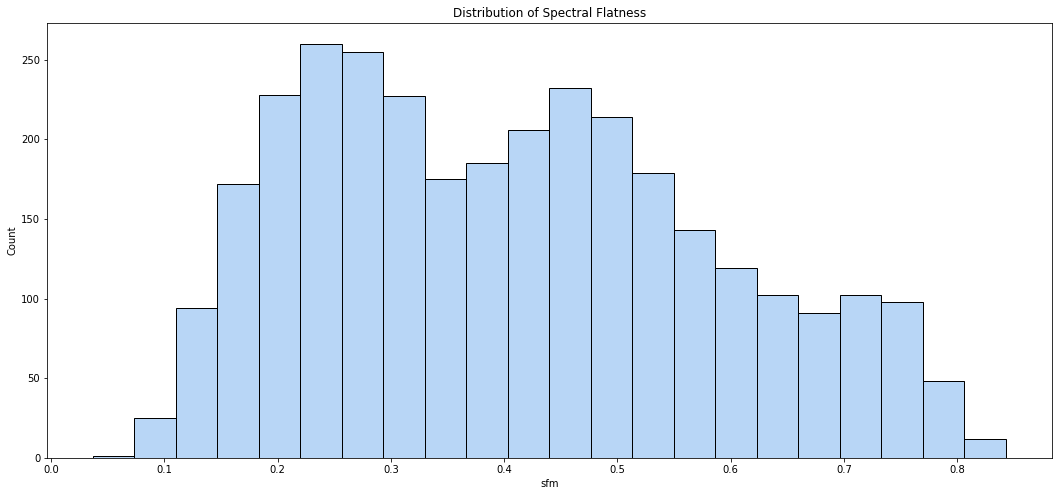

In [20]:
plt.figure(figsize=(18,8))
sns.histplot(dataframe.sfm, color=sns.color_palette('pastel')[0])
plt.title("Distribution of Spectral Flatness")
plt.show()

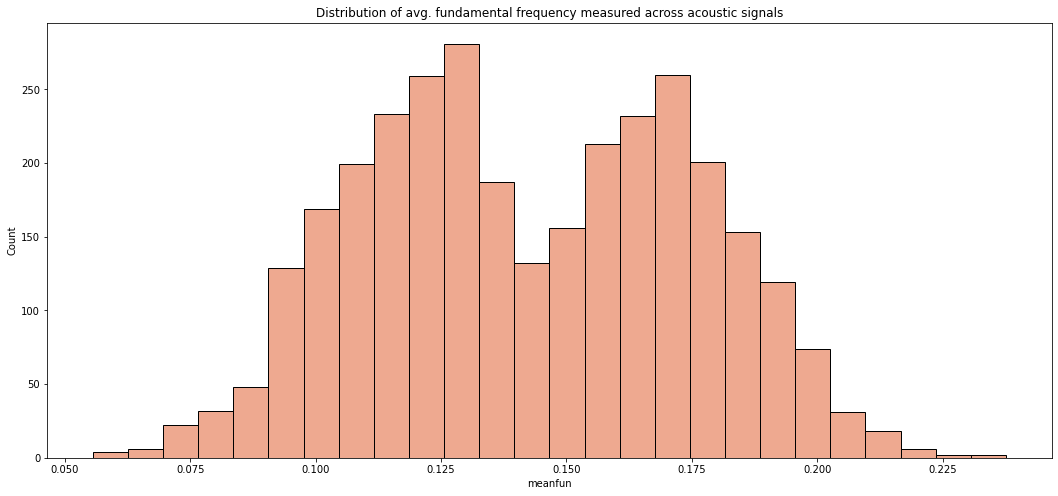

In [21]:
plt.figure(figsize=(18,8))
sns.histplot(dataframe.meanfun, color=sns.color_palette('flare')[0])
plt.title("Distribution of avg. fundamental frequency measured across acoustic signals")
plt.show()

Label Balance verification

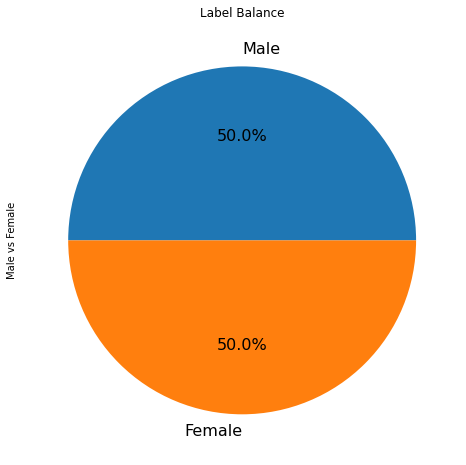

In [22]:
plt.figure(figsize=(18, 8))
dataframe.label.value_counts().plot(kind="pie",
                                           fontsize=16,
                                           labels=["Male", "Female"],
                                           ylabel="Male vs Female",
                                           autopct='%1.1f%%');
plt.title("Label Balance")
plt.show()

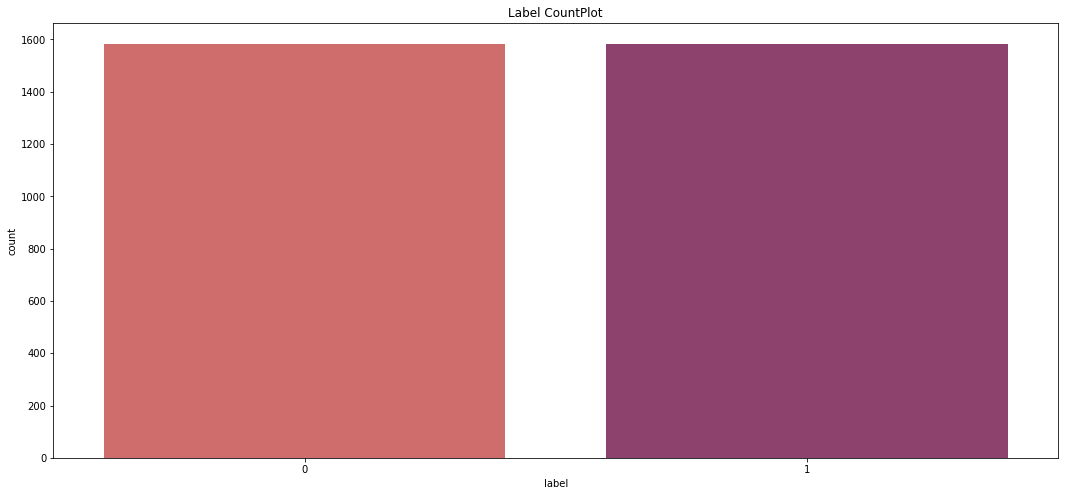

In [23]:
plt.figure(figsize=(18, 8))
sns.countplot(x="label",data=dataframe, palette="flare")
plt.title("Label CountPlot")
plt.show()

As we can see, luck is in our favour and there is no class imbalance.

### Correlation Heatmap

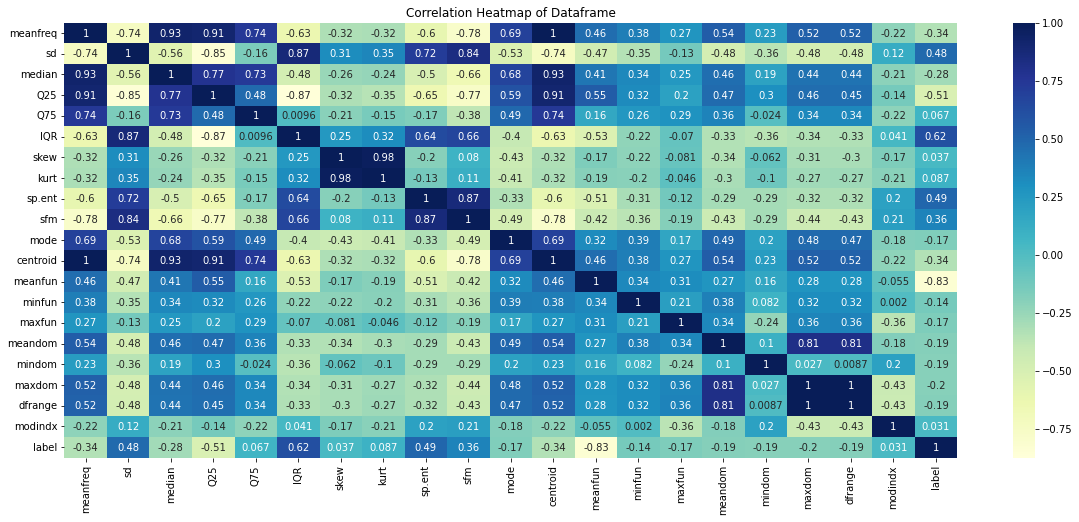

In [24]:
plt.figure(figsize=(20, 8))
dataplot = sns.heatmap(dataframe.corr(), cmap="YlGnBu", annot=True)
plt.title("Correlation Heatmap of Dataframe")
plt.show()

### Correlation Coefficient

A correlation coefficient is a numerical measure of some type of correlation, meaning a statistical relationship between two variables.

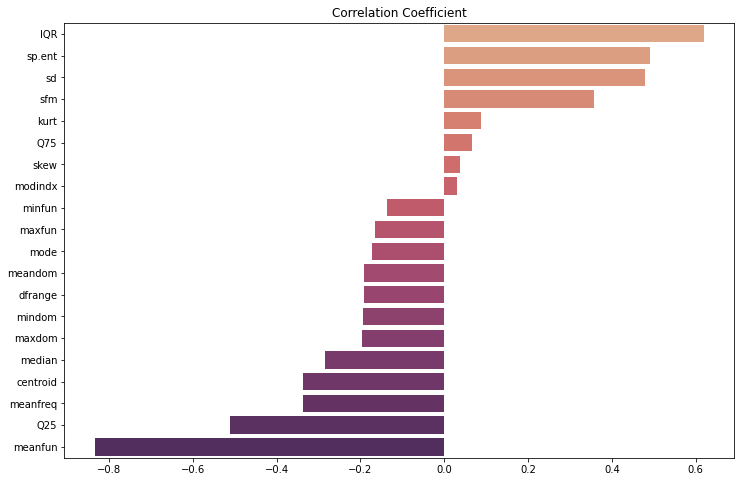

In [25]:
plt.figure(figsize=(12,8))
data = dataframe.corr()["label"].sort_values(ascending=False)
indices = data.index
labels = []
corr = []
for i in range(1, len(indices)):
    labels.append(indices[i])
    corr.append(data[i])
sns.barplot(x=corr, y=labels, palette='flare')
plt.title('Correlation Coefficient')
plt.show()

# ML Model Building
We approach the problem by building ML Models from simple to complex models on training set and then assess them on the basis of their scores on validation dataset.

## Gaussian Naive Bayes

In [26]:
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, Y_train)

GaussianNB()

In [27]:
nb_val_accuracy = nb_classifier.score(X_val, Y_val)
print(f"Validation Accuracy of Naive Bayes Classifier is: {(nb_val_accuracy)*100:.2f}%")

Validation Accuracy of Naive Bayes Classifier is: 88.01%


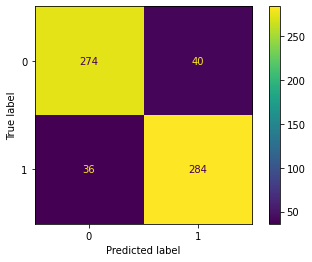

In [28]:
sklearn.metrics.ConfusionMatrixDisplay.from_estimator(nb_classifier, X_val, Y_val)

## Logisitic Regression

In [29]:
lr_classifier = LogisticRegression(solver='liblinear')
lr_classifier.fit(X_train, Y_train)

LogisticRegression(solver='liblinear')

In [30]:
lr_val_accuracy = lr_classifier.score(X_val, Y_val)
print(f"Validation Accuracy of Logisitic Regression Classifier is: {(lr_val_accuracy )*100:.2f}%")

Validation Accuracy of Logisitic Regression Classifier is: 91.96%


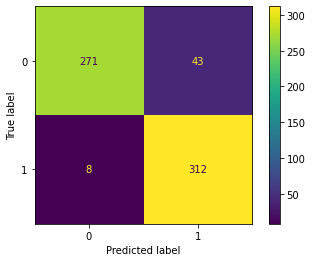

In [31]:
sklearn.metrics.ConfusionMatrixDisplay.from_estimator(lr_classifier, X_val, Y_val)

## KNN Classifier

In [32]:
knn_classifier = KNeighborsClassifier(n_neighbors=3) # We always use odd numbers for this to avoid ties
knn_classifier.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=3)

In [33]:
knn_val_accuracy = knn_classifier.score(X_val, Y_val)
print(f"Validation Accuracy of KNN Clf. is: {(knn_val_accuracy)*100:.2f}%")

Validation Accuracy of KNN Clf. is: 69.87%


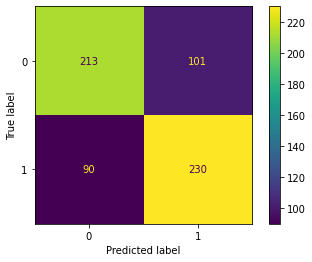

In [34]:
sklearn.metrics.ConfusionMatrixDisplay.from_estimator(knn_classifier, X_val, Y_val)

## Support Vector Classifier

In [35]:
svc_classifier = SVC(kernel = 'linear')
svc_classifier.fit(X_train, Y_train)

SVC(kernel='linear')

In [36]:
svc_val_accuracy = svc_classifier.score(X_val, Y_val)
print(f"Validation Accuracy of Support Vector Classifier is: {(svc_val_accuracy)*100:.2f}%")

Validation Accuracy of Support Vector Classifier is: 92.27%


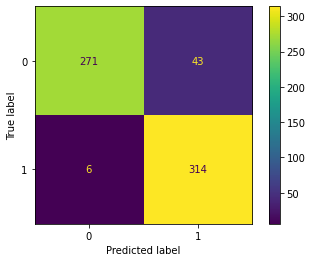

In [37]:
sklearn.metrics.ConfusionMatrixDisplay.from_estimator(svc_classifier, X_val, Y_val)

## Decision Tree Classifier

In [38]:
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train, Y_train)

DecisionTreeClassifier()

In [39]:
dt_val_accuracy = dt_classifier.score(X_val, Y_val)
print(f"Validation Accuracy of Decision Tree Clf. is: {(dt_val_accuracy)*100:.2f}%")

Validation Accuracy of Decision Tree Clf. is: 95.74%


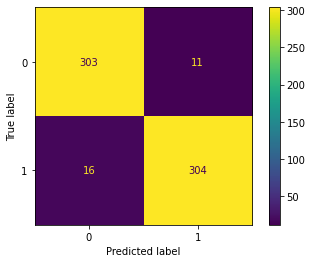

In [40]:
sklearn.metrics.ConfusionMatrixDisplay.from_estimator(dt_classifier, X_val, Y_val)

## Random Forest Classifier

In [41]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, Y_train)

RandomForestClassifier()

In [42]:
rf_val_accuracy = rf_classifier.score(X_val, Y_val)
print(f"Validation Accuracy of Random Forest Classifier is: {(rf_val_accuracy)*100:.2f}%")

Validation Accuracy of Random Forest Classifier is: 98.42%


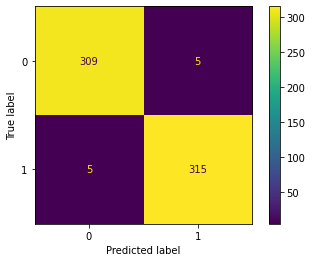

In [43]:
sklearn.metrics.ConfusionMatrixDisplay.from_estimator(rf_classifier, X_val, Y_val)

## MLP Classifier

In [44]:
mlp_classifier = MLPClassifier()
mlp_classifier.fit(X_train, Y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier()

In [45]:
mlp_val_accuracy = mlp_classifier.score(X_val, Y_val)
print(f"Validation Accuracy of MLP Classifier is: {(mlp_val_accuracy)*100:.2f}%")

Validation Accuracy of MLP Classifier is: 95.11%


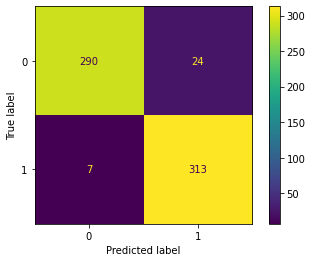

In [46]:
sklearn.metrics.ConfusionMatrixDisplay.from_estimator(mlp_classifier, X_val, Y_val)

# Scoring ML Model Performance

## List of Validation Accuracies

In [47]:
print(f"Validation Accuracy of Naive Bayes Classifier is: {(nb_val_accuracy)*100:.2f}%")
print(f"Validation Accuracy of Logisitic Regression is: {(lr_val_accuracy )*100:.2f}%")
print(f"Validation Accuracy of SVC is: {(svc_val_accuracy )*100:.2f}%")
print(f"Validation Accuracy of KNN Clf. is: {(knn_val_accuracy)*100:.2f}%")
print(f"Validation Accuracy of Decision Tree Clf. is: {(dt_val_accuracy)*100:.2f}%")
print(f"Validation Accuracy of Random Forest Classifier is: {(rf_val_accuracy)*100:.2f}%")
print(f"Validation Accuracy of MLP Classifier is: {(mlp_val_accuracy)*100:.2f}%")

Validation Accuracy of Naive Bayes Classifier is: 88.01%
Validation Accuracy of Logisitic Regression is: 91.96%
Validation Accuracy of SVC is: 92.27%
Validation Accuracy of KNN Clf. is: 69.87%
Validation Accuracy of Decision Tree Clf. is: 95.74%
Validation Accuracy of Random Forest Classifier is: 98.42%
Validation Accuracy of MLP Classifier is: 95.11%


## Plotting the same

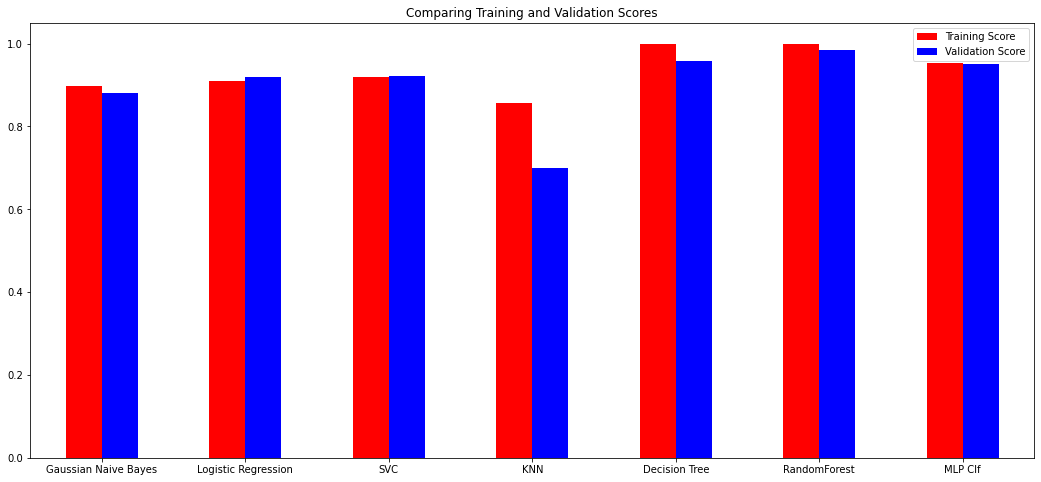

In [48]:
trainScores = [nb_classifier.score(X_train, Y_train),lr_classifier.score(X_train, Y_train) ,svc_classifier.score(X_train, Y_train),knn_classifier.score(X_train, Y_train),dt_classifier.score(X_train, Y_train),rf_classifier.score(X_train, Y_train),mlp_classifier.score(X_train,Y_train)]
valScores = [nb_val_accuracy,lr_val_accuracy,svc_val_accuracy,knn_val_accuracy,dt_val_accuracy,rf_val_accuracy,mlp_val_accuracy]
indices = ['Gaussian Naive Bayes', 'Logistic Regression', 'SVC', 'KNN','Decision Tree', 'RandomForest', 'MLP Clf']
scores = pd.DataFrame({'Training Score': trainScores,'Validation Score': valScores}, index=indices)
plot = scores.plot.bar(figsize=(18, 8), rot=0, color=['red', 'blue'])
plt.title('Comparing Training and Validation Scores')
plt.show()

# Conclusion

The following models performed the best -


1.   Random Forest Classifier - 98.42%
2.   Decision Tree Classifier - 95.74%
3.   MLP(Multi-layer Perceptron) Classifier - 95.11%

# Model Visualization

We look at our best performing model.


In [52]:
from sklearn.tree import export_graphviz

rf_classifier.fit(X_train, Y_train) 
estimator = rf_classifier.estimators_[5]

export_graphviz(estimator, 
                out_file='tree.dot',
                rounded = True, proportion = False, 
                precision = 2, filled = True)

In [54]:
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

0

In [55]:
from IPython.display import Image
Image(filename = 'tree.png')